In [15]:
%matplotlib inline
import numpy as np
import scipy.linalg as la
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

import scipy.sparse as sp
from scipy.sparse.linalg import spsolve, lsqr

from numpy.linalg import cond, norm, inv


import pandas as pd

import pickle
import os.path

import warnings
warnings.simplefilter('ignore')

from scipy.optimize import minimize_scalar

from poly_basis import *

# Forcing Terms

In [16]:
def foo1(node):
    return node[0]*2
def exact1(node):
    return node[0]

# l=3
def foo2(node):
    return (node[0]**2 - node[1]**2) * 6
def exact2(node):
    return (node[0]**2 - node[1]**2)

def foo3(node):
    return (node[0]**2 - node[1]**2) * node[2] * 12

def exact3(node):
    return (node[0]**2 - node[1]**2) * node[2]

# l=4
def foo4(node):
    return (3*node[0]**2 - node[1]**2)*node[1]*node[2] * 20
def exact4(node):
    return (3*node[0]**2 - node[1]**2)*node[1]*node[2]

# Parameters

In [17]:
file_name = 'sphere_harm_deg4_dynamic_stencil'

node_sets = ['spiral']
ns = [200 * 2**i for i in range(0,4)]
#ns = [400]
print(ns)

#rbf_labels = ['r^3', 'r^4*log(r)', 'r^5', 'r^6*log(r)', 'r^7', 'r^8*log(r)', 'r^9', 'gaussian']
#rbf_labels = ['r^6*log(r)', 'r^7', 'r^8*log(r)', 'r^9']
rbf_labels = ['r^3', 'r^5', 'r^9', 'gaussian']
#rbf_labels = ['gaussian']
#rbf_labels = ['r^3', 'r^9']
#rbf_labels = ['r^3']

#epsilons = [1, .5, .25, .1, .05]
#epsilons = [1, .05]
#epsilons = [.1, .01, .001]
epsilons = [1]
#epsilons = [4, 2, 1, .5, .25]

#basis_degs = [3, 4] # -1 for no terms
basis_degs = range(1,6) # -1 for no terms
basis_types = ['s'] * len(basis_degs) # p for polynomial and s for spherical harmonics



foo, exact = foo4, exact4

#stencil_sizes = [7, 11, 31]
#stencil_sizes = [11, 23, 31]
stencil_sizes = [31]
auto_choose_stencil = True
def choose_stencil_size(deg):
    return max(2*(deg+1)**2, 11)

calculate_weights_cond = True
calculate_stencil_conds = True

optimize_epsilon = True
target_cond = 10**14
optimize_all_stencils = True

[200, 400, 800, 1600]


# RBFs

In [18]:
rbf_dict = {}

even_tol = 1e-14

def rbf(r):
    return r**3
def d_phi_dr_div_r(r):
    return 3 * r
rbf_dict['r^3'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    if abs(r)< even_tol:
        return 0
    return r**4 * np.log(r)
def d_phi_dr_div_r(r):
    if abs(r)< even_tol:
        return 0
    return r**2 * (1 + 4*np.log(r))
rbf_dict['r^4*log(r)'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    return r**5
def d_phi_dr_div_r(r):
    return 5 * r**3
rbf_dict['r^5'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    if abs(r)< even_tol:
        return 0
    return r**6 * np.log(r)
def d_phi_dr_div_r(r):
    if abs(r)< even_tol:
        return 0
    return r**4 * (1 + 6*np.log(r))
rbf_dict['r^6*log(r)'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    return r**7
def d_phi_dr_div_r(r):
    return 7 * r**5
rbf_dict['r^7'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    if abs(r)< even_tol:
        return 0
    return r**8 * np.log(r)
def d_phi_dr_div_r(r):
    if abs(r)< even_tol:
        return 0
    return r**6 * (1 + 8*np.log(r))
rbf_dict['r^8*log(r)'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    return r**9
def d_phi_dr_div_r(r):
    return 9 * r**7
rbf_dict['r^9'] = (rbf, d_phi_dr_div_r)

# RBFs with Shape Parameter
shape_rbfs = []

def rbf(r):
    return np.exp(-(epsilon*r)**2)
def d_phi_dr_div_r(r):
    return -2 * epsilon**2 * np.exp(-(epsilon*r)**2)
rbf_dict['gaussian'] = (rbf, d_phi_dr_div_r)
shape_rbfs += ['gaussian']



def grad_rbf(node, node_center):
    r = dist(node, node_center)
    return d_phi_dr_div_r(r) * (np.array(node) - np.array(node_center))

########################################################################################
#
# misc
#
########################################################################################

def dist(node1, node2):
    return np.sqrt( (node1[0]-node2[0])**2 + (node1[1]-node2[1])**2 + (node1[2]-node2[2])**2 )

# Epsilon Optimization

In [19]:
def root_find(eps, dist_mat, P, target_cond):
    num_basis = P.shape[1]
    A = np.exp(-(eps*dist_mat)**2)
    AP = np.block([[A,P],[P.T, np.zeros((num_basis,num_basis))]])
    return np.log(cond(AP)/target_cond) ** 2

def check_eps(eps, dist_mat):
    A = np.exp(-(eps*dist_mat)**2)
    return cond(A)

In [20]:
def skeel_cond(A):
    return np.max(np.abs( np.abs(inv(A))@np.abs(A) ))

# Loops

In [21]:
columns = ['node_set', 'rbf',  'epsilon', 'basis_deg', 'basis_type', 'N', 'stencil_size', 'max_error', 'rel_L2_error']
data = pd.DataFrame(columns=columns)

assert len(basis_types) == len(basis_degs)
for node_set in node_sets:
    for n in ns:
        print('n: %d' % n)
        # generate nodes
        if node_set == 'spiral':
            indices = np.arange(0, n, dtype=float) + 0.5
            phi = np.arccos(1 - 2*indices/n)
            theta = np.pi * (1 + 5**0.5) * indices
            xs, ys, zs = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)
            nodes = np.array([(x,y,z) for x,y,z in zip(xs,ys,zs)])
        projectors = [np.eye(3) - np.outer(node, node) for node in nodes]

        # generate stencils
        tree = cKDTree(np.array(nodes))
        

        # generate weights
        for rbf_label in rbf_labels:
            print('\trbf: ' + rbf_label)
            rbf, d_phi_dr_div_r = rbf_dict[rbf_label]
            skip_no_epsilon = False
            if optimize_epsilon:
                epsilons = [1]
            for epsilon in epsilons:
                if skip_no_epsilon:
                    continue
                if rbf_label not in shape_rbfs:
                    #epsilon = ''
                    skip_no_epsilon = True
                else:
                    print('\t\tepsilon %f' % epsilon)
                
                for stencil_size in stencil_sizes:
                    if auto_choose_stencil:
                        if stencil_size != stencil_sizes[0]:
                            continue
                            # skip if doing more than one stencil size
                    if stencil_size > n:
                        stencil_size = n
                    
                    stencils = [tree.query(node, stencil_size)[1] for node in nodes]
                    print('\t\t\tstencil size: %d' % stencil_size)
                    
                    for basis_deg, basis_type in zip(basis_degs, basis_types):
                        if calculate_stencil_conds:
                            largest_stencil_cond = 0
                        else:
                            largest_stencil_cond = '-'
                            skeel = '-'
                        if auto_choose_stencil:
                            stencil_size = choose_stencil_size(basis_deg)
                            stencils = [tree.query(node, stencil_size)[1] for node in nodes]
                            
                        if stencil_size > n:
                            stencil_size = n
                            
                        if auto_choose_stencil:
                            print('\t\t\tstencil size changed: %d' % stencil_size)
                        
                        weights = np.zeros((n, stencil_size))
                        row_index = [r for r in range(n) for c in range(stencil_size)]
                        col_index = np.zeros((n, stencil_size))
                        for i, stencil in enumerate(stencils):

                            col_index[i] = stencil
                            nn = np.array([nodes[i] for i in stencil])
                            nn_proj = [projectors[i] for i in stencil]
                            center_x, center_y, center_z = nn[0]
                            
                            if basis_type == 'p':
                                P, rhs_x, rhs_y, rhs_z = get_poly_basis(basis_deg, nn, nn_proj)
                            elif basis_type == 's':
                                P, rhs_x, rhs_y, rhs_z = gen_sphere_harm_basis(basis_deg, nn, nn_proj)
                            
                            if optimize_epsilon and (i==0 or optimize_all_stencils) and not skip_no_epsilon:
                                # optimize cond for first stencil
                                dist_mat = np.array([[dist(node, node_center) for node in nn] for node_center in nn])
                                optimization_result = minimize_scalar(root_find, args=(dist_mat, P, target_cond))
                                epsilon = optimization_result['x']
                                if i==0:
                                    print(print('\t\tepsilon %f' % epsilon))

                            A = np.array([[rbf(dist(node, node_center)) for node in nn] for node_center in nn])
                            #P = np.array([[1, x-center_x, y-center_y, z-center_z] for x,y,z in nn])
                            #P, rhs_x, rhs_y, rhs_z = get_poly_basis(basis_deg, nn, nn_proj)

                            num_basis = P.shape[1]

                            AP = np.block([[A,P],[P.T, np.zeros((num_basis,num_basis))]])
                            
                            if calculate_stencil_conds:
                                my_cond = cond(AP)
                                if i==0:
                                    skeel = skeel_cond(AP)
                                if my_cond > largest_stencil_cond:
                                    largest_stencil_cond = my_cond

                            rhsAs = np.array([ [ nn_proj[j]@grad_rbf(node, node_center) for j, node in enumerate(nn) ]
                                                for node_center in nn] )

                            rhsA = rhsAs[:,:,0] # only the x coordinates
                            rhs = np.block([[rhsA],
                                            [rhs_x]])
                            weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
                            weights[i] = (weights_grad@weights_grad)[0]

                            rhsA = rhsAs[:,:,1] # only the y coordinates
                            rhs = np.block([[rhsA],
                                            [rhs_y]])
                            weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
                            weights[i] += (weights_grad@weights_grad)[0]

                            rhsA = rhsAs[:,:,2] # only the z coordinates
                            rhs = np.block([[rhsA],
                                            [rhs_z]])
                            weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
                            weights[i] += (weights_grad@weights_grad)[0]

                        C = sp.csc_matrix((weights.ravel(), (row_index, col_index.ravel())),shape=(n,n))

                        # solve steady-state
                        C = sp.vstack( [sp.hstack([C, np.ones((n,1))], format='csr'), 
                                        np.block([np.ones((1,n)), np.zeros((1,1))]) ], format='csr')
                        rhs = [-foo(node) for node in nodes] + [0]
                        if calculate_weights_cond:
                            weights_cond = cond(C.todense())
                        else:
                            weights_cond = '-'
                        u = spsolve(C, rhs)
                        u = u[:-1]
                        u_true = np.array([exact(node) for node in nodes])
                        data = data.append( 
                            {'node_set': node_set, 'rbf':rbf_label, 'epsilon': epsilon,
                             'basis_deg':np.int(basis_deg), 'basis_type' : basis_type,
                             'N':n, 'stencil_size':stencil_size,
                             'max_error':np.max( np.abs(u-u_true ) ), 
                             'rel_L2_error':la.norm(u-u_true)/la.norm(u_true),
                             'stencil_cond': largest_stencil_cond, 
                             'skeel_cond' : skeel,
                             'weights_cond': weights_cond,
                             'target_cond' : target_cond}, ignore_index=True)


n: 200
	rbf: r^3
			stencil size: 31
			stencil size changed: 11
			stencil size changed: 18
			stencil size changed: 32
			stencil size changed: 50
			stencil size changed: 72
	rbf: r^5
			stencil size: 31
			stencil size changed: 11
			stencil size changed: 18
			stencil size changed: 32
			stencil size changed: 50
			stencil size changed: 72
	rbf: r^9
			stencil size: 31
			stencil size changed: 11
			stencil size changed: 18
			stencil size changed: 32
			stencil size changed: 50
			stencil size changed: 72
	rbf: gaussian
		epsilon 1.000000
			stencil size: 31
			stencil size changed: 11
		epsilon -0.024988
None
			stencil size changed: 18
		epsilon 0.111072
None
			stencil size changed: 32
		epsilon -0.265253
None
			stencil size changed: 50
		epsilon -0.407445
None
			stencil size changed: 72
		epsilon 0.561128
None
n: 400
	rbf: r^3
			stencil size: 31
			stencil size changed: 11
			stencil size changed: 18
			stencil size changed: 32
			stencil size changed: 50
			stencil size c

In [22]:
display(data[:10])

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,skeel_cond,stencil_cond,target_cond,weights_cond
0,spiral,r^3,1,1,s,200,11,0.072789,0.205268,370.508756,9.933789e+02,1.000000e+14,26.277439
1,spiral,r^3,1,2,s,200,18,0.067349,0.160672,497.050569,4.637348e+03,1.000000e+14,60.066850
2,spiral,r^3,1,3,s,200,32,0.051725,0.089827,1566.123435,1.325688e+05,1.000000e+14,117.763098
3,spiral,r^3,1,4,s,200,50,0.008754,0.019666,5729.178593,1.322323e+06,1.000000e+14,344.266518
4,spiral,r^3,1,5,s,200,72,0.000007,0.000045,20003.143439,2.864326e+06,1.000000e+14,1137.040557
5,spiral,r^5,1,1,s,200,11,0.044401,0.121516,1317.133226,3.991310e+03,1.000000e+14,54.671832
6,spiral,r^5,1,2,s,200,18,0.027217,0.069367,2844.553617,1.490315e+04,1.000000e+14,44.012592
7,spiral,r^5,1,3,s,200,32,0.014929,0.035213,5318.659957,8.619965e+04,1.000000e+14,56.683447
8,spiral,r^5,1,4,s,200,50,0.002241,0.005168,24065.460771,5.935846e+05,1.000000e+14,59.420149
9,spiral,r^5,1,5,s,200,72,0.000007,0.000045,50649.095499,1.607684e+06,1.000000e+14,49.979829


# Write to File

In [23]:
i = 0
file_name_num = file_name + '_' + str(i) + '.pickle'
while os.path.isfile(os.path.join('pickles',file_name_num)):
    i += 1
    file_name_num = file_name + '_' + str(i) + '.pickle'

f = open(os.path.join('pickles',file_name_num), 'wb')
pickle.dump(data, f)
f.close()
print(file_name_num)

sphere_harm_deg4_dynamic_stencil_0.pickle


In [24]:
read_data = data

# Read from File

In [14]:
file_to_read = 'sphere_harm_deg4_0.pickle'
f = open(os.path.join('pickles',file_to_read), 'rb')
read_data = pickle.load(f)
f.close()
read_data['N'] = read_data['N'].apply(pd.to_numeric, errors='coerce')
read_data['label'] = read_data['rbf'] + ' ' + read_data['epsilon'].astype(str)

rbf_labels = read_data.rbf.unique()
basis_degs = read_data.basis_deg.unique()
stencil_sizes = read_data.stencil_size.unique()
ns = read_data.N.unique()
epsilons = read_data.epsilon.unique()
#basis_degs = read_data.basis_deg.unique()

#read_data['sqrtN'] = np.sqrt(read_data['N'])

In [15]:
display(read_data[:10])

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,skeel_cond,stencil_cond,target_cond,weights_cond,label
0,spiral,r^3,1,3,s,200,51,0.018893,0.042039,-,-,1.000000e+14,-,r^3 1
1,spiral,r^3,1,4,s,200,51,0.004419,0.009445,-,-,1.000000e+14,-,r^3 1
2,spiral,r^5,1,3,s,200,51,0.006398,0.017764,-,-,1.000000e+14,-,r^5 1
3,spiral,r^5,1,4,s,200,51,0.001740,0.004135,-,-,1.000000e+14,-,r^5 1
4,spiral,r^9,1,3,s,200,51,0.081279,0.104118,-,-,1.000000e+14,-,r^9 1
5,spiral,r^9,1,4,s,200,51,0.000226,0.000533,-,-,1.000000e+14,-,r^9 1
6,spiral,gaussian,0.427114,3,s,200,51,0.000060,0.000158,-,-,1.000000e+14,-,gaussian 0.42711399855813964
7,spiral,gaussian,0.426671,4,s,200,51,0.000032,0.000091,-,-,1.000000e+14,-,gaussian 0.4266708914428212
8,spiral,r^3,1,3,s,400,51,0.007572,0.016496,-,-,1.000000e+14,-,r^3 1
9,spiral,r^3,1,4,s,400,51,0.001089,0.002136,-,-,1.000000e+14,-,r^3 1


In [16]:
rbf_labels

array(['r^3', 'r^5', 'r^9', 'gaussian'], dtype=object)

# Plots

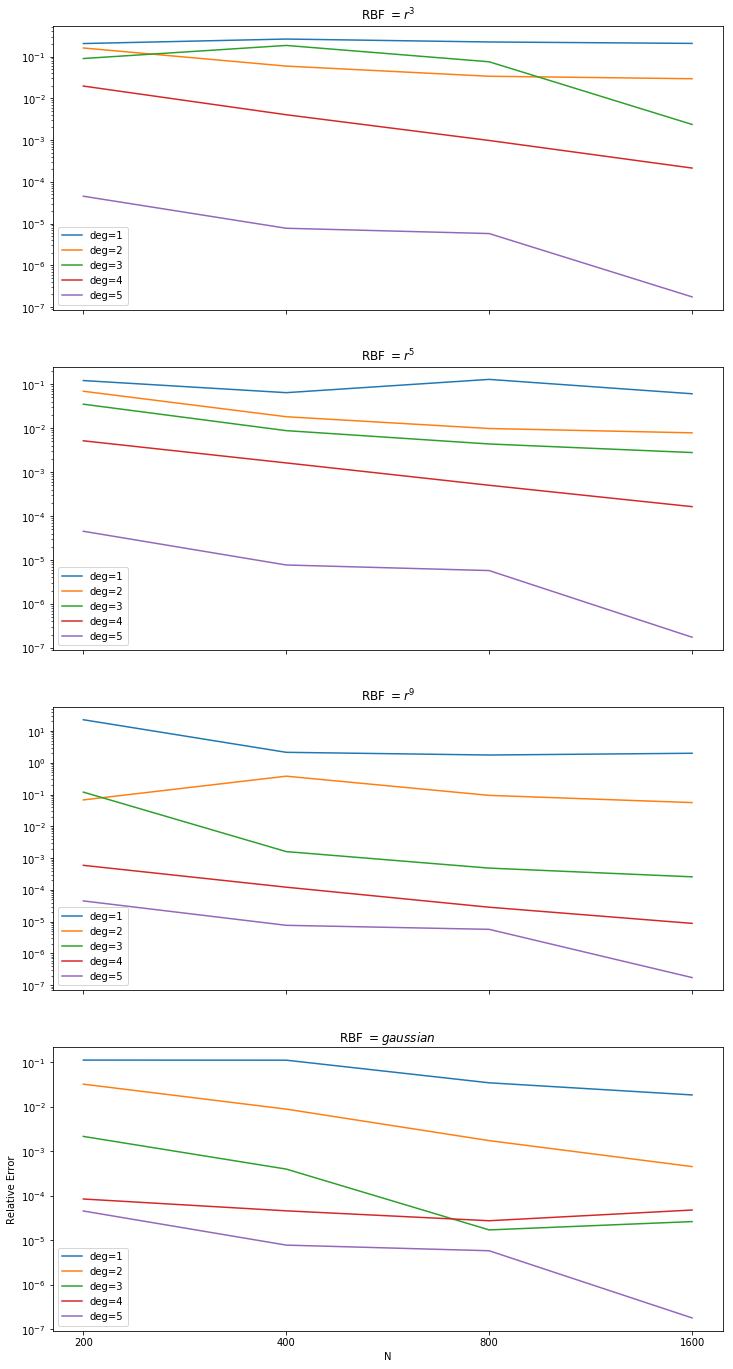

In [25]:
fig, ax_s = plt.subplots(len(rbf_labels), sharex=True, figsize=(12,24))

for i, rbf in enumerate(rbf_labels):
    legends = []
    read_data_slice = read_data[read_data.rbf==rbf]    
    for basis_deg in basis_degs:
        ax_s[i].loglog( 'N', 'rel_L2_error', data=read_data_slice[read_data_slice.basis_deg==basis_deg])
        ax_s[i].set_title('RBF $=' + rbf + '$')
    ax_s[i].legend( ['deg='+str(basis_deg) for basis_deg in basis_degs] )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Relative Error')
#plt.title('Spherical Harmonics - Stencil size $31$')
plt.show()

In [25]:
display(read_data[:10])

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,skeel_cond,stencil_cond,target_cond,weights_cond,label
0,spiral,r^3,1,3,s,200,51,0.018893,0.042039,-,-,1.000000e+14,-,r^3 1
1,spiral,r^3,1,4,s,200,51,0.004419,0.009445,-,-,1.000000e+14,-,r^3 1
2,spiral,r^5,1,3,s,200,51,0.006398,0.017764,-,-,1.000000e+14,-,r^5 1
3,spiral,r^5,1,4,s,200,51,0.001740,0.004135,-,-,1.000000e+14,-,r^5 1
4,spiral,r^9,1,3,s,200,51,0.081279,0.104118,-,-,1.000000e+14,-,r^9 1
5,spiral,r^9,1,4,s,200,51,0.000226,0.000533,-,-,1.000000e+14,-,r^9 1
6,spiral,gaussian,0.427114,3,s,200,51,0.000060,0.000158,-,-,1.000000e+14,-,gaussian 0.42711399855813964
7,spiral,gaussian,0.426671,4,s,200,51,0.000032,0.000091,-,-,1.000000e+14,-,gaussian 0.4266708914428212
8,spiral,r^3,1,3,s,400,51,0.007572,0.016496,-,-,1.000000e+14,-,r^3 1
9,spiral,r^3,1,4,s,400,51,0.001089,0.002136,-,-,1.000000e+14,-,r^3 1


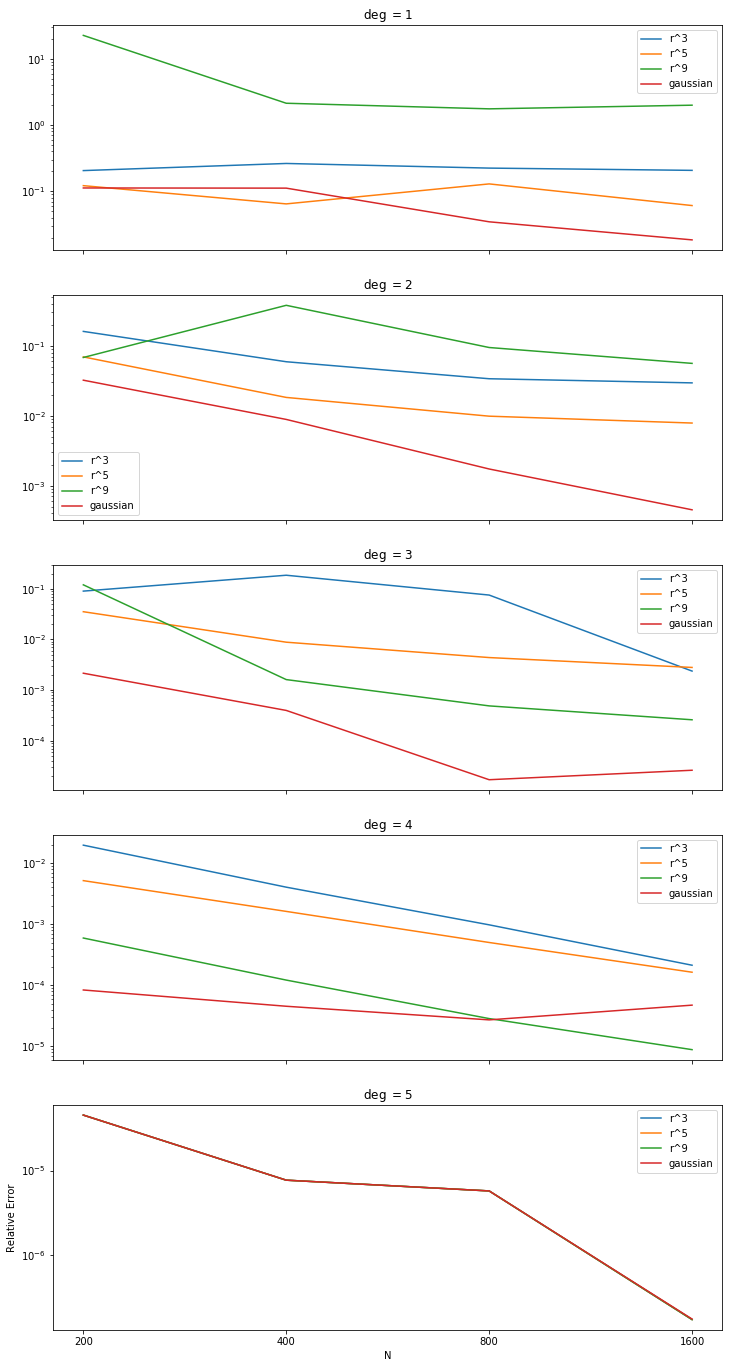

In [26]:
fig, ax_s = plt.subplots(len(basis_degs), sharex=True, figsize=(12,24))

for i, basis_deg in enumerate(basis_degs):
    legends = []
    read_data_slice = read_data[read_data.basis_deg==basis_deg]
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', 'rel_L2_error', data=read_data_slice[read_data_slice.rbf==rbf])
        ax_s[i].set_title('deg $=' + str(basis_deg) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Relative Error')
#plt.title('Spherical Harmonics - Stencil size $31$')
plt.show()

In [27]:
display(read_data[:10])

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,skeel_cond,stencil_cond,target_cond,weights_cond,label
0,spiral,r^3,1,0,s,200,31,0.500051,0.493573,678.758658,7.787012e+03,1.000000e+14,66.514532,r^3 1
1,spiral,r^3,1,1,s,200,31,0.033155,0.028796,655.484808,7.621692e+03,1.000000e+14,64.473415,r^3 1
2,spiral,r^3,1,2,s,200,31,0.003710,0.002850,639.936886,7.651137e+03,1.000000e+14,33.784299,r^3 1
3,spiral,r^3,1,3,s,200,31,0.000049,0.000095,1702.330395,1.403435e+05,1.000000e+14,2537.789443,r^3 1
4,spiral,r^5,1,0,s,200,31,0.009532,0.009258,5246.872018,8.923462e+04,1.000000e+14,42.407831,r^5 1
5,spiral,r^5,1,1,s,200,31,0.717953,0.302289,4836.136055,1.779663e+05,1.000000e+14,2298.036983,r^5 1
6,spiral,r^5,1,2,s,200,31,0.003166,0.003005,5205.706285,8.782019e+04,1.000000e+14,45.542807,r^5 1
7,spiral,r^5,1,3,s,200,31,0.000049,0.000095,4762.481802,8.049276e+04,1.000000e+14,112.410421,r^5 1
8,spiral,r^9,1,0,s,200,31,0.533456,0.423741,13827.217413,6.144768e+06,1.000000e+14,7765.512550,r^9 1
9,spiral,r^9,1,1,s,200,31,0.004061,0.002894,15020.557075,9.705750e+05,1.000000e+14,53.617790,r^9 1


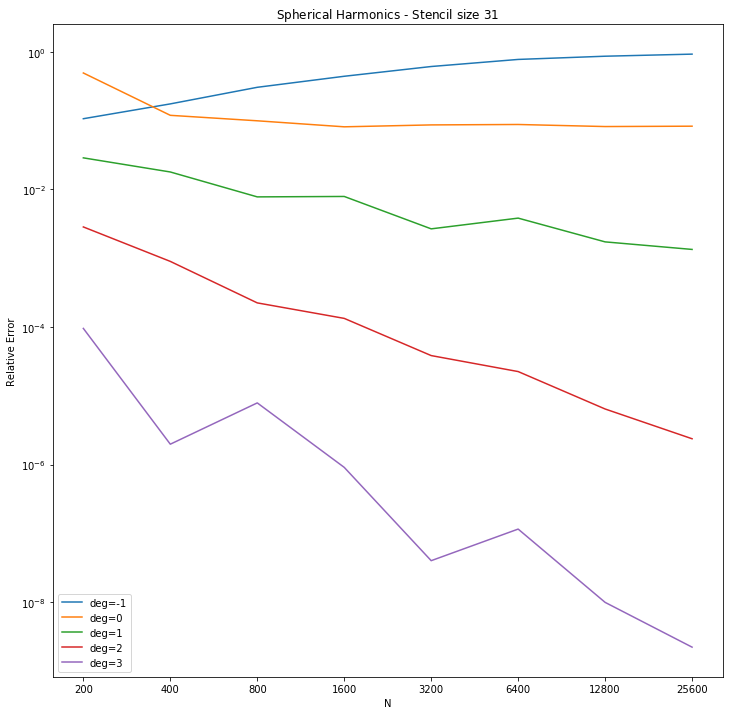

In [39]:
fig, ax_s = plt.subplots(1, sharex=True, figsize=(12,12))

#for i, k in enumerate(basis_degs):
#    legends = []
#    read_data_stencil = read_data[read_data.basis_deg==k]    
for basis_deg in basis_degs[:-1]:
    ax_s.loglog( 'N', 'rel_L2_error', data=read_data[read_data.basis_deg==basis_deg])
    #ax_s.set_title('Basis Degree Size $=' + str(k) + '$')
ax_s.legend( ['deg='+str(basis_deg) for basis_deg in basis_degs] )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Relative Error')
plt.title('Spherical Harmonics - Stencil size $31$')
plt.show()

######################################################
#
# Stencil size = 31
#
######################################################

In [41]:
display(read_data[:10])

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,stencil_cond,target_cond,weights_cond,label
0,spiral,r^3,1,-1,s,200,101,0.002075,0.002003,-,1.000000e+14,-,r^3 1
1,spiral,r^3,1,0,s,200,101,0.002130,0.002057,-,1.000000e+14,-,r^3 1
2,spiral,r^3,1,1,s,200,101,0.001953,0.001884,-,1.000000e+14,-,r^3 1
3,spiral,r^3,1,2,s,200,101,0.000569,0.000544,-,1.000000e+14,-,r^3 1
4,spiral,r^3,1,3,s,200,101,0.000049,0.000095,-,1.000000e+14,-,r^3 1
5,spiral,r^3,1,4,s,200,101,0.000049,0.000095,-,1.000000e+14,-,r^3 1
6,spiral,r^3,1,5,s,200,101,0.000049,0.000095,-,1.000000e+14,-,r^3 1
7,spiral,r^3,1,6,s,200,101,0.000049,0.000095,-,1.000000e+14,-,r^3 1
8,spiral,r^3,1,7,s,200,101,0.000049,0.000095,-,1.000000e+14,-,r^3 1
9,spiral,r^3,1,-1,s,400,101,0.001046,0.000817,-,1.000000e+14,-,r^3 1


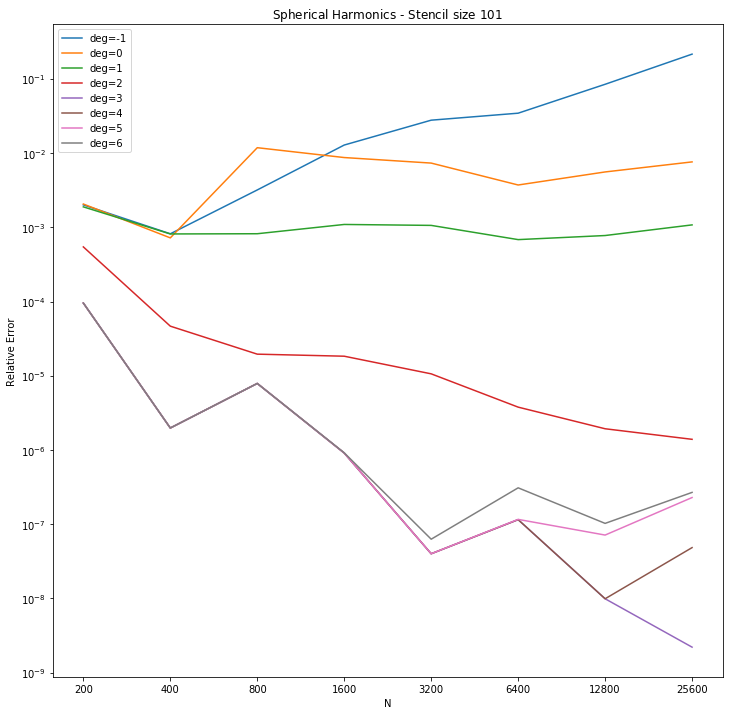

In [42]:
fig, ax_s = plt.subplots(1, sharex=True, figsize=(12,12))

#for i, k in enumerate(basis_degs):
#    legends = []
#    read_data_stencil = read_data[read_data.basis_deg==k]    
for basis_deg in basis_degs[:-1]:
    ax_s.loglog( 'N', 'rel_L2_error', data=read_data[read_data.basis_deg==basis_deg])
    #ax_s.set_title('Basis Degree Size $=' + str(k) + '$')
ax_s.legend( ['deg='+str(basis_deg) for basis_deg in basis_degs] )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Relative Error')
plt.title('Spherical Harmonics - Stencil size $101$')
plt.show()

######################################################
#
# Stencil size = 101
#
######################################################

In [ ]:
fig, ax_s = plt.subplots(2, sharex=True, figsize=(12,12))
ax_s[0].loglog('N', 'max_error', data=read_data[read_data.stencil_size==31])
ax_s[0].set_title('Max error')
ax_s[1].loglog('N', 'rel_L2_error', data=read_data[read_data.stencil_size==31])
ax_s[1].set_title('Relative $L_2$ error')
plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
#plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
#plt.ylabel('Relative Error')

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[(read_data.stencil_size==k) & (read_data.epsilon==1)]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', 'max_error', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Max Error')
plt.show()

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[read_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', 'max_error', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Max Error')
plt.show()

# shape_search_2 - target cond 10^14

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[read_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].plot( 'N', 'epsilon', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Shape Parameter')
plt.show()

# shape_search_2 - target cond 10^14

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[read_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', 'stencil_cond', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Stencil Condition Number')
plt.show()

# shape_search_2 - target cond 10^14

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[read_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', 'max_error', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Max Error')
plt.show()

# shape_search_1 - target cond 10^12

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[read_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].plot( 'N', 'epsilon', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Shape Parameter')
plt.show()

# shape_search_1 - target cond 10^12

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[read_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', 'stencil_cond', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Stencil Condition Number')
plt.show()

# shape_search_1 - target cond 10^12

In [141]:
display(read_data[-10:])

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,stencil_cond,target_cond,weights_cond
2,spiral,gaussian,0.076463,0,p,400,11,0.003763,0.003277,1.000022e+12,1.000000e+12,-
3,spiral,gaussian,0.616967,0,p,400,31,0.000033,0.000025,1.000021e+12,1.000000e+12,-
4,spiral,gaussian,0.132301,0,p,800,11,0.002034,0.002088,1.000025e+12,1.000000e+12,-
5,spiral,gaussian,0.934870,0,p,800,31,0.000066,0.000061,1.000016e+12,1.000000e+12,-
6,spiral,gaussian,0.253591,0,p,1600,11,0.001471,0.001399,1.000051e+12,1.000000e+12,-
7,spiral,gaussian,1.390357,0,p,1600,31,0.000150,0.000142,1.000017e+12,1.000000e+12,-
8,spiral,gaussian,0.451956,0,p,3200,11,0.000484,0.000539,1.000146e+12,1.000000e+12,-
9,spiral,gaussian,2.037936,0,p,3200,31,0.000168,0.000152,1.000147e+12,1.000000e+12,-
10,spiral,gaussian,0.733747,0,p,6400,11,0.000360,0.000341,1.000116e+12,1.000000e+12,-
11,spiral,gaussian,2.946618,0,p,6400,31,0.000112,0.000118,4.026584e+16,1.000000e+12,-


# For Meeting

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))


for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[(read_data.stencil_size==k) & (read_data.rbf=='gaussian')]
    for epsilon in epsilons:
        ax_s[i].loglog( 'N', 'max_error', data=read_data_stencil[read_data_stencil.epsilon==epsilon])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( ['Gaussian $\epsilon$=%s' % epsilon for epsilon in epsilons] )

plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Max Error')

#plt.show()

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))


for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[(read_data.stencil_size==k) & (read_data.rbf=='gaussian')]
    for epsilon in epsilons:
        ax_s[i].loglog( 'N', 'rel_L2_error', data=read_data_stencil[read_data_stencil.epsilon==epsilon])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( ['Gaussian $\epsilon$=%s' % epsilon for epsilon in epsilons] )

plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('rel_L2_error')

#plt.show()

In [ ]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))


for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[(read_data.stencil_size==k) & (read_data.rbf=='gaussian')]
    for epsilon in epsilons:
        ax_s[i].loglog( 'N', 'stencil_cond', data=read_data_stencil[read_data_stencil.epsilon==epsilon])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( ['Gaussian $\epsilon$=%s' % epsilon for epsilon in epsilons] )

plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('stencil_cond')

#plt.show()

In [ ]:
display(read_data)

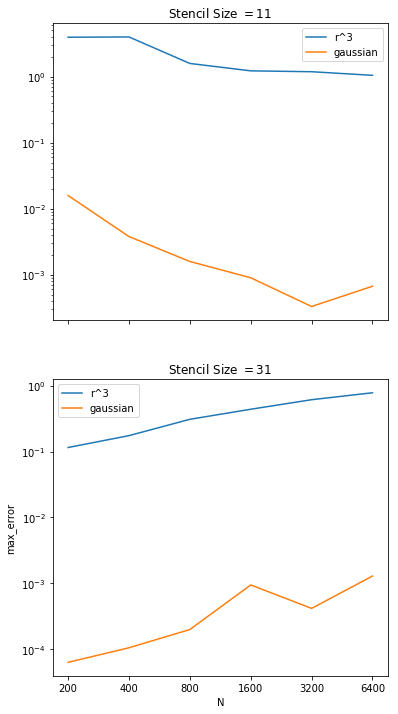

In [61]:
# Filter data
plot_data = read_data
plot_data = plot_data[plot_data.node_set=='spiral']
#plot_data = plot_data[plot_data.rbf=='r^3']
#plot_data = plot_data[plot_data.stencil_size==31]
plot_data = plot_data[plot_data.basis_deg==-1]

sub_plot_by = stencil_sizes
error_type = 'max_error'

# Generate Plots
fig, ax_s = plt.subplots(len(sub_plot_by), sharex=True, figsize=(len(sub_plot_by)*3,12))
for i, k in enumerate(sub_plot_by):
    legends = []
    plot_data_stencil = plot_data[plot_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', error_type, data=plot_data_stencil[plot_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel(error_type)
plt.show()

########################################################################################
#
# Not Augmented
#     meeting_0.pickle
#
########################################################################################

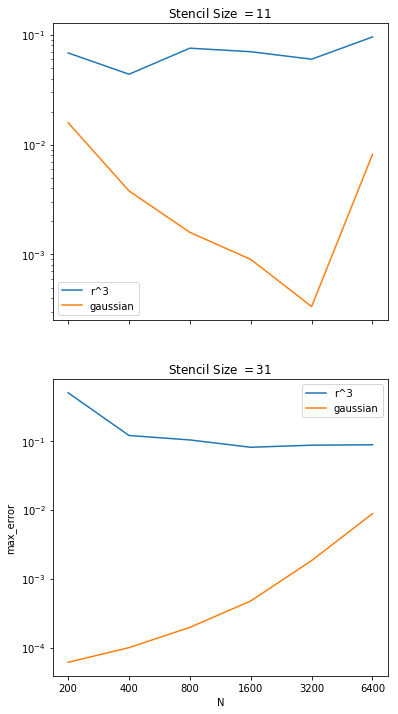

In [62]:
# Filter data
plot_data = read_data
plot_data = plot_data[plot_data.node_set=='spiral']
#plot_data = plot_data[plot_data.rbf=='r^3']
#plot_data = plot_data[plot_data.stencil_size==31]
plot_data = plot_data[plot_data.basis_deg==0]

sub_plot_by = stencil_sizes
error_type = 'max_error'

# Generate Plots
fig, ax_s = plt.subplots(len(sub_plot_by), sharex=True, figsize=(len(sub_plot_by)*3,12))
for i, k in enumerate(sub_plot_by):
    legends = []
    plot_data_stencil = plot_data[plot_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', error_type, data=plot_data_stencil[plot_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel(error_type)
plt.show()

########################################################################################
#
# Agumented with constant
#     meeting_0.pickle
#
########################################################################################

In [ ]:
# Filter data
plot_data = read_data
plot_data = plot_data[plot_data.node_set=='spiral']
#plot_data = plot_data[plot_data.rbf=='r^3']
#plot_data = plot_data[plot_data.stencil_size==31]
plot_data = plot_data[plot_data.basis_deg==1]

sub_plot_by = stencil_sizes
error_type = 'max_error'

# Generate Plots
fig, ax_s = plt.subplots(len(sub_plot_by), sharex=True, figsize=(len(sub_plot_by)*3,12))
for i, k in enumerate(sub_plot_by):
    legends = []
    plot_data_stencil = plot_data[plot_data.stencil_size==k]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', error_type, data=plot_data_stencil[plot_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
#plt.tick_params(axis='x', which='minor', bottom=False, top=False, labelbottom=False)
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel(error_type)
plt.show()

########################################################################################
#
# Augmented with linear terms
#     meeting_0.pickle
#
########################################################################################

In [17]:
file_to_read = 'cond_numbers_0.pickle'
f = open(os.path.join('pickles',file_to_read), 'rb')
read_data = pickle.load(f)
f.close()
read_data['N'] = read_data['N'].apply(pd.to_numeric, errors='coerce')
read_data['label'] = read_data['rbf'] + ' ' + read_data['epsilon'].astype(str)

rbf_labels = read_data.rbf.unique()
stencil_sizes = read_data.stencil_size.unique()
ns = read_data.N.unique()
epsilons = read_data.epsilon.unique()

display(read_data)

,node_set,rbf,epsilon,basis_deg,basis_type,N,stencil_size,max_error,rel_L2_error,stencil_cond,weights_cond,label
0,spiral,r^3,0.2,1,p,200,7,0.050125,22.559223,4.992054e+02,42.897164,r^3 0.2
1,spiral,gaussian,0.2,1,p,200,7,0.041990,9.203220,1.504166e+08,56.653412,gaussian 0.2
2,spiral,r^3,0.2,1,p,400,7,0.026098,4.307138,1.341322e+03,86.338668,r^3 0.2
3,spiral,gaussian,0.2,1,p,400,7,0.016095,2.013794,1.180640e+09,105.259963,gaussian 0.2
4,spiral,r^3,0.2,1,p,800,7,0.036502,20.743179,3.726019e+03,173.927786,r^3 0.2
5,spiral,gaussian,0.2,1,p,800,7,0.015350,1.834184,9.392575e+09,221.679517,gaussian 0.2
6,spiral,r^3,0.2,1,p,1600,7,0.039006,21.101553,1.047230e+04,359.237964,r^3 0.2
7,spiral,gaussian,0.2,1,p,1600,7,0.006518,0.829760,7.661370e+10,468.887098,gaussian 0.2
8,spiral,r^3,0.2,1,p,3200,7,0.052004,87.619923,2.955462e+04,721.847822,r^3 0.2
9,spiral,gaussian,0.2,1,p,3200,7,0.001273,2.069589,6.175983e+11,921.067813,gaussian 0.2


Text(0,0.5,'max_error')

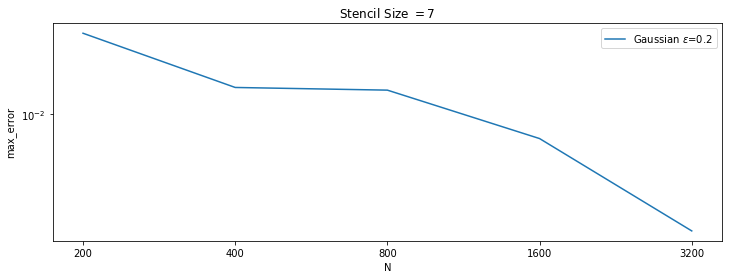

In [18]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,4))


for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[(read_data.stencil_size==k) & (read_data.rbf=='gaussian')]
    for epsilon in epsilons:
        ax_s.loglog( 'N', 'max_error', data=read_data_stencil[read_data_stencil.epsilon==epsilon])
        ax_s.set_title('Stencil Size $=' + str(k) + '$')
    ax_s.legend( ['Gaussian $\epsilon$=%s' % epsilon for epsilon in epsilons] )

plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('max_error')

#plt.show()


Text(0,0.5,'rel_L2_error')

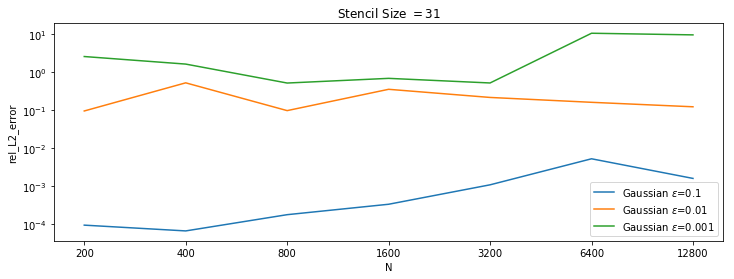

In [23]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,4))


for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[(read_data.stencil_size==k) & (read_data.rbf=='gaussian')]
    for epsilon in epsilons:
        ax_s.loglog( 'N', 'rel_L2_error', data=read_data_stencil[read_data_stencil.epsilon==epsilon])
        ax_s.set_title('Stencil Size $=' + str(k) + '$')
    ax_s.legend( ['Gaussian $\epsilon$=%s' % epsilon for epsilon in epsilons] )

plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('rel_L2_error')

#plt.show()

In [36]:
import test

Hello Mintaek!
